<img align=right src="images/inmas.png" width=130x />

# Notebook 02a - Simple Linear Regression

Material covered in this notebook:

- How to perform simple linear regressions on data

This notebook follows along the notes [here](Notes/2_SimpleLinearRegression+InferenceForSlope.pdf)


### Prerequisite
Notebook 01

--------------------

In [ ]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sbn

# Linear Regression

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/ciaran-evans/bryozoan-data-paper/master/bryozoan_data_fixed.csv')
data.info()

In [ ]:
sbn.scatterplot(data=data,  x="Mass", y="Metabolic");

# Linear Regression in Python

Many existing libraries have implementations that will quickly estimate the parameters of a linear regression. In the case of `Python`, we'll primarily use `statsmodels`. In a separate notebook, we include `NumPy` implementations for our own simple linear regression variant using the closed-form solutions and numerical optimization.



## Modeling Approaches

There are two modeling interfaces for `statmodels`:

1. The direct approach that assumes you have pre-specified the design matrix $X$ and have separated out $Y$, or
2. The *R* like approach using model formulas that automatically constructs the design matrix and response vector.

We will focus on the second approach here.

### Formula-approach

On the other hand, the formula approach relates closely to how we specify the linear model. Generally, we prefer using the formulas compared to manually crafting design matrices.

The syntax is given as:

```python
smf.ols('y ~ x ', data = my_data)
```

where `my_data` is a pandas data frame with columns named `x` and `y`.



In [ ]:
# Specify the model
model_formulation = smf.ols("Metabolic ~ Mass", data = data)

# Fit the model
results = model_formulation.fit()

# View parameters
results.params

## Model Summary Overview

To view the overarching characteristics of the model, we would need to call `.summary()`. A lot of this information is over kill for our purposes. The goal is to be able to pick out the pieces that we need.

In [ ]:
model_summary = results.summary()
print(model_summary)

model_anova = statsmodels.stats.anova.anova_lm(results)
print(model_anova)

## Check Your Understanding

1. Which number(s) in this output tell us whether or not there is a statistically significant relationship between mass and metabolic rate?

2. Which number(s) in this output tell us the magnitude of the relationship between mass and metabolic rate?

3. Which number(s) in this output describe the sampling distribution of the slope paraemter?


## Predictions

With the model, the response values available in $y$ may now be predicted using the parameter estimates of our model under:

$$\hat y = X \hat \beta$$

In [ ]:
# Retrieve beta estimates from statsmodels
beta_hat = results.params

# Compute estimates
Y_hat = beta_hat[0] + data.Mass*beta_hat[1]

In [ ]:
# Show data points
plt.scatter(data.Mass, data.Metabolic,  color='black', zorder = 2)

# Graph the line of best fit
plt.plot(data.Mass, Y_hat, color='blue', linewidth = 3, zorder = 3)

# Plot details
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(rf"Estimated values for $\beta_0 = {beta_hat[0]:.04f}, \beta_1 = {beta_hat[1]:.04f}$ ")
plt.suptitle('Linear Regression')
plt.show()

## Residual

The "residuals" of the fit are the difference between the model's prediction $\hat y = X \hat \beta$ and the original $y$ values:

$$r = y - \hat y = y - X \hat \beta$$

We can modify the prediction graph slightly to show the residual fit given by the "red" lines.

In [ ]:
# Show data points
plt.scatter(data.Mass, data.Metabolic,  color='black', zorder = 2)

# Graph the line of best fit
plt.plot(data.Mass, Y_hat, color='blue', linewidth = 3, zorder = 3)

# Show residual lines
plt.vlines(data.Mass, data.Metabolic, Y_hat, color="red", zorder = 1)

# Plot details
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(rf"Estimated values for $\beta_0 = {beta_hat[0]:.04f}, \beta_1 = {beta_hat[1]:.04f}$ ")
plt.suptitle('Linear Regression')
plt.show()

The residuals can be obtained from the `results` object under:

In [ ]:
residuals = results.resid

Alternatively, we could compare the predicted values with the fit values ourselves:

In [ ]:
residuals = data.Metabolic - Y_hat

With the residuals in hand, we do want to check to see if the residuals vs. fitted plot exhibits **Homoscedasticity** behavior (same error is consistent). If the graph displays **Heteroscedasticity** behavior, we would need to re-evaluate this model.

In [ ]:
plt.scatter(data.Mass, residuals)
plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.xlabel(r'$x$')
plt.ylabel('Residuals')
plt.title("Comparing residuals against covariate")
plt.show()

When looking at the graph, we are seeking to see if the data points are equally scattered (homoscedasticity). If the points are **not** equally scatter, then we would have a case of **heteroscedasticity**.

### Verify Assumptions

In order for a linear regression model to be appropriate, a number of conditions must be met.

- **L**inearity
- **I**ndependence
- **N**ormality
- **E**quality of variance

These conditions are mainly related to the distribution of the residuals.

Assumption |	Consequence |	Diagnostic	| Solution
----| ---| --|--
Independence | Inaccurate inference | Common sense/context | Use a different technique/ don’t model  
$\mathbb{E}[\varepsilon] = 0$ | Lack of model fit | Plot of residuals vs. Fitted values | Transform either input $x$and/or $y$
$\operatorname{Var}(\varepsilon)=\sigma^2$ | Inaccurate inference | Plot of residuals v. fitted values | Transform  $y$
$\varepsilon \sim N(\mu, \sigma)$  | If extreme, inaccurate inference | QQ plot | Transform  $y$ |

For more details [see here](https://mathvoices.ams.org/featurecolumn/2022/03/01/ordinary-least-squares/).

### Expectation of residuals

One assumption of the linear model is the expectation or the average value across residuals is 0. We can verify that by taking the mean:

In [ ]:
results.resid.mean()

### Assessing Normality of Residuals

We can employ visual methods for assessing the quality of the residuals through either graphing them with a histogram or a **Q–Q** (quantile-quantile) plot.  The **Q-Q plot** focuses on comparing two distributions to each other to see if they come from populations with a common distribution. We add a 45-degree reference line that helps us visually assess this information. In particular, if points fall on this line, they should come from the same distribution. If they are significantly far away, then the underlying distributions are different.

In [ ]:
import scipy.stats as stats
import seaborn as sbn

residuals = data.Metabolic - Y_hat

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sbn.distplot(residuals, fit=stats.norm, ax=ax1)
ax1.set_title('Distribution of Residuals')
ax1.set_xlabel('Residual')
ax1.set_ylabel('Probability')
_ = stats.probplot(residuals.ravel(), plot=ax2)

## Make a judgment call...

Based on these diagnostics, do you think the assumptions are met in this case? How might you explain your reasoning to your biologist collaborator?

## Confidence Interval for Slope

In [ ]:
from scipy.stats import t
t.ppf(1-0.05/2, 821) ## get critical value

# Your Turn: Modeling Palmer Penguins

In this exercise, we return the Palmer Penguin data set.

In [ ]:
import seaborn as sbn
penguins = sbn.load_dataset("penguins")

penguins.head()

## a: Fit a Simple Linear Regression

Fit a simple linear regression between `body_mass_g` (y) and `flipper_length_mm` (x)  and look at the model summary:

What is the equation of the fitted model?

---

answer

---

## b: Interpret Model Parameters

Interpret the slope and the intercept. That is, for every 1-unit change in `flipper_length_mm` what happens?

---

answer

---

Are the coefficients significant?

## c: Creating Predictions

If we had two additional penguins added to the data set with Flipper Length equivalent to 175 and 200 mm respectively, what would their body mass be?

## d: Residuals

Confirm that the mean of residuals generated by the model is zero.

## e: Confidence Interval

Calculate a confidence interval for the slope and interpret it in context.

## Check your understanding

Which covariate, A or B, do you think would be a stronger predictor of a continuous response Y? Explain your reasoning in a sentence or two.

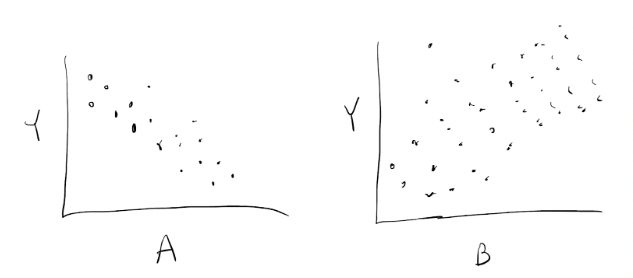


 To reject the null hypothesis related to a slope do we want the test statistic to be big or small? Explain your reasoning.